Library pre-processing 

In [1]:
import math, os, sys
import numpy as np
import itertools
import skimage
from skimage import measure, morphology
from skimage.transform import resize
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage


from PIL import Image
import pandas as pd

read and unzip data

In [2]:
import zipfile

local_zip = './data/data_capstone_project.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('./data')
zip_ref.close()

define each directory 

In [3]:
base_dir = './data/data_capstone_project'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training cat/dog pictures
train_dermatitis_dir = os.path.join(train_dir, 'dermatitis')
train_eczema_dir = os.path.join(train_dir, 'eczema')
train_psoriasis_dir = os.path.join(train_dir, 'psoriasis')

# Directory with our validation cat/dog pictures
test_dermatitis_dir = os.path.join(test_dir, 'dermatitis')
test_eczema_dir = os.path.join(test_dir, 'eczema')
test_psoriasis_dir = os.path.join(test_dir, 'psoriasis')

In [4]:
train_dermatitis_fnames = os.listdir( train_dermatitis_dir )
train_eczema_fnames = os.listdir( train_eczema_dir )
train_psoriasis_fnames = os.listdir( train_psoriasis_dir )

print(train_dermatitis_fnames[:10])
print(train_eczema_fnames[:10])
print(train_psoriasis_fnames[:10])

['dermatitis-1.jpg', 'dermatitis-10.jpg', 'dermatitis-100.jpg', 'dermatitis-101.jpg', 'dermatitis-102.jpg', 'dermatitis-103.jpg', 'dermatitis-104.jpg', 'dermatitis-105.jpg', 'dermatitis-106.jpg', 'dermatitis-107.jpg']
['eczema-1.jpg', 'eczema-10.jpg', 'eczema-100.jpg', 'eczema-101.jpg', 'eczema-102.jpg', 'eczema-103.jpg', 'eczema-104.jpg', 'eczema-105.jpg', 'eczema-106.jpg', 'eczema-107.jpg']
['psoriasis-1.jpg', 'psoriasis-10.jpg', 'psoriasis-100.jpg', 'psoriasis-101.jpg', 'psoriasis-102.jpg', 'psoriasis-103.jpg', 'psoriasis-104.jpg', 'psoriasis-105.jpg', 'psoriasis-106.jpg', 'psoriasis-107.jpg']


total number of images 

In [5]:
print('total training dermatitis images :', len(os.listdir(      train_dermatitis_dir ) ))
print('total training eczema images :', len(os.listdir(      train_eczema_dir ) ))
print('total training psoriasis images :', len(os.listdir(      train_psoriasis_dir ) ))

print('total testing dermatitis images :', len(os.listdir( test_dermatitis_dir ) ))
print('total testing eczema images :', len(os.listdir( test_eczema_dir ) ))
print('total testing psoriasis images :', len(os.listdir( test_psoriasis_dir ) ))

total training dermatitis images : 500
total training eczema images : 500
total training psoriasis images : 500
total testing dermatitis images : 100
total testing eczema images : 100
total testing psoriasis images : 100


data preprocessing 

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=128,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
test_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size=128,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))


Found 1500 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


show image

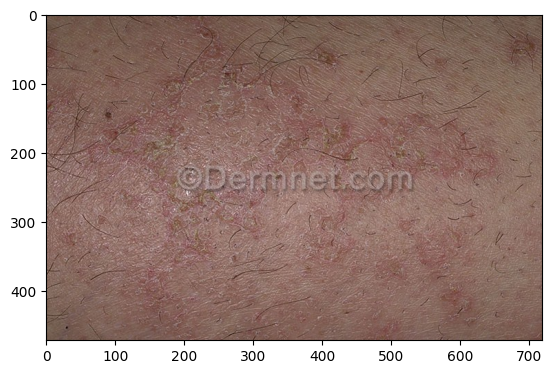

In [7]:
image = imread('./data/data_capstone_project/train/eczema/eczema-100.jpg')
plt.imshow(image)
plt.show()

In [8]:
print (train_generator.class_indices)

label_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('label.txt', 'w') as f:
    f.write(label_txt)

{'dermatitis': 0, 'eczema': 1, 'psoriasis': 2}


pre-trained model 

In [9]:
IMG_SHAPE = (224, 224, 3)
base_model = tf.keras.applications.ResNet152V2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

feature extraction

In [10]:
base_model.trainable = False 
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

Mengelompokkkan klasifikasi 3 jenis penyakit dengan deep learning 

In [11]:
import tensorflow.keras 
from tensorflow.keras import backend as K 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers 
from tensorflow.keras.utils import to_categorical 


mempersiapkan data pengujian 

In [12]:
X_test = []
y_test = []

X_test = np.array(X_test)
y_test = np.array(y_test)

In [13]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation = 'softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 7, 7, 2048)        58331648  
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          589856    
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 58,921,603
Trainable params: 589,955
Non-trainable params: 58,331,648
_________________________________________________________________


training

In [14]:
history = model.fit_generator(train_generator,
                                epochs=20,
                                validation_data=test_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
12/12 [==============================] - 487s 41s/step - loss: 2.2704 - accuracy: 0.3680 - val_loss: 1.0605 - val_accuracy: 0.4233
Epoch 2/20
12/12 [==============================] - 407s 34s/step - loss: 1.0277 - accuracy: 0.3987 - val_loss: 1.0179 - val_accuracy: 0.3767
Epoch 3/20
12/12 [==============================] - 400s 33s/step - loss: 0.9848 - accuracy: 0.4013 - val_loss: 1.0025 - val_accuracy: 0.4233
Epoch 4/20
12/12 [==============================] - 1221s 102s/step - loss: 0.9510 - accuracy: 0.4247 - val_loss: 0.9715 - val_accuracy: 0.4500
Epoch 5/20
12/12 [==============================] - 590s 49s/step - loss: 0.9186 - accuracy: 0.4420 - val_loss: 0.9540 - val_accuracy: 0.4433
Epoch 6/20
12/12 [==============================] - 871s 73s/step - loss: 0.8969 - accuracy: 0.4520 - val_loss: 0.9475 - val_accuracy: 0.4533
Epoch 7/20
12/12 [==============================] - 1837s 153s/step - 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


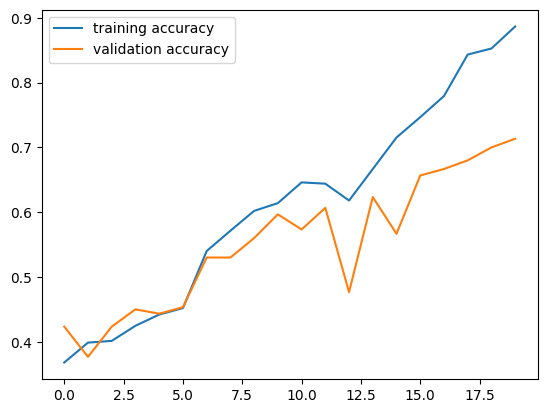

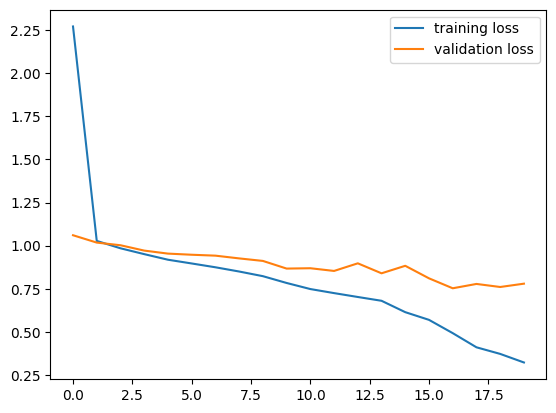

In [15]:
import matplotlib.pyplot as plt

# Check the available keys in the history object
print(history.history.keys())

# Plot accuracy
if 'accuracy' in history.history:
    plt.plot(history.history["accuracy"], label="training accuracy")
if 'val_accuracy' in history.history:
    plt.plot(history.history["val_accuracy"], label="validation accuracy")

plt.legend()
plt.show()

# Plot loss
if 'loss' in history.history:
    plt.plot(history.history["loss"], label="training loss")
if 'val_loss' in history.history:
    plt.plot(history.history["val_loss"], label="validation loss")

plt.legend()
plt.show()


In [16]:
# Get the number of trainable variables
num_trainable_variables = len(model.trainable_variables)

print('Number of trainable variables = {}'.format(num_trainable_variables))

Number of trainable variables = 4


mengggunakan model 

In [17]:
print(train_generator)

In [18]:
# Obtain a batch of images and labels from the test generator
image_batch, label_batch = next(test_generator)

# Predict the label for a specific image in the batch
n = 20
input_image = image_batch[n][np.newaxis, ...]
print("The actual label is:", label_batch[n])

prediction = model.predict(input_image)
print("The predicted label is:", prediction[0])

The actual label is: [0. 1. 0.]
The predicted label is: [0.10577256 0.8584946  0.03573293]


evaluasi model 

In [19]:
#memeriksa matriks model 
print(model.metrics_names)
#evaluasi data set 
print(model.evaluate(x = X_test3, y = y_test3))


['loss', 'accuracy']


NameError: name 'X_test3' is not defined